## Загрузка и рисование файлов

In [234]:
# импорт бибилиотек
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter
from scipy import stats
#библиотеки для графиков
import matplotlib.pyplot as plt
import seaborn as sns
#библиотеки для модели
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression


In [235]:
#считывание данных
#NH3
nh3_2rh_25t = pd.read_excel('Данные для МО/NH3_100_200_300_500 ppm.xlsx', sheet_name='Untitled')
nh3_25rh_25t = pd.read_excel('Данные для МО/NH3_100_200_300_500 ppm_RH25%.xlsx', sheet_name='Untitled')
nh3_50rh_25t = pd.read_excel('Данные для МО/NH3_100_200_300_500 ppm_RH50%.xlsx', sheet_name='Untitled')
nh3_75rh_25t = pd.read_excel('Данные для МО/NH3_100_200_300_500 ppm_RH75%.xlsx', sheet_name='Untitled')
nh3_2rh_25t_another_ppm = pd.read_excel('Данные для МО/NH3_10_25_50 ppm_RH2%_Room temperature.xlsx', sheet_name='Untitled')

# NO2
no2_2rh_25t = pd.read_excel('Данные для МО/NO2_2_5_10 ppm_ RH_2%.xlsx', sheet_name='Untitled')
no2_25rh_25t = pd.read_excel('Данные для МО/NO2_2_5_10 ppm_RH_25%.xlsx', sheet_name='Untitled')
no2_50rh_25t = pd.read_excel('Данные для МО/NO2_2_5_10 ppm_RH_50%.xlsx', sheet_name='Untitled')
no2_75rh_25t = pd.read_excel('Данные для МО/NO2_2_5_10 ppm_RH_75%.xlsx', sheet_name='Untitled')
no2_2rh_50t = pd.read_excel('Данные для МО/NO2_2_5_10 ppm_temp_50.xlsx', sheet_name='Untitled')
no2_2rh_70t = pd.read_excel('Данные для МО/NO2_2_5_10 ppm_temp_70_RH2%.xlsx', sheet_name='Untitled')
no2_2rh_90t = pd.read_excel('Данные для МО/NO2_2_5_10 ppm_temp_90.xlsx', sheet_name='Untitled')

In [236]:
nh3_2rh_25t

,R [Ом],Time [с]
0,0.000000,0.0
1,1916.370361,0.5
2,1917.799194,1.0
3,1914.129395,1.5
4,1916.431519,2.0
...,...,...
12595,1980.580811,6300.0
12596,1982.384766,6300.5
12597,1980.985718,6301.0
12598,1981.931763,6301.5


In [237]:
#строим график зависимости сопротивления от времени
def dependency_graphs(gas, title):
    gas = gas.iloc[1:]# для того чтобы убрать (0,0)
    # Построим точечный график
    plt.figure(figsize=(6, 4))# размер графика
    sns.scatterplot(x='Time [с]', y='R [Ом]', data=gas)# что и откуда берем

    plt.xlabel('Время')#ну как бы просто название
    plt.ylabel('Сопротивление')#название игрека
    title_string = f'Точечный график зависимости сопротивления от времени газа {title}'
    plt.title(title_string)
    plt.grid(True)#добавим сеточку

    return plt.show()

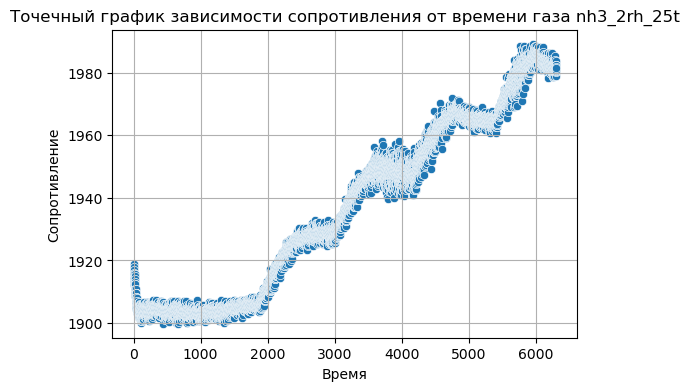

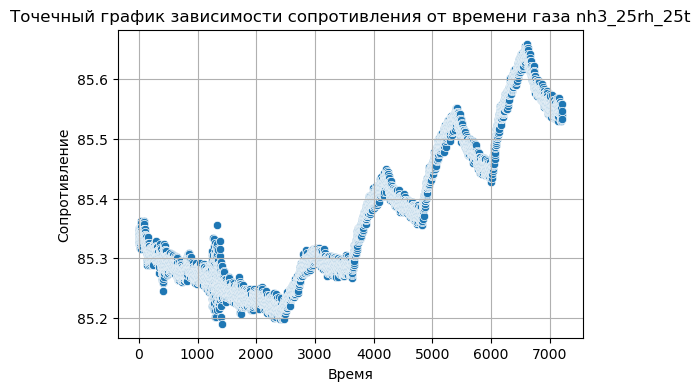

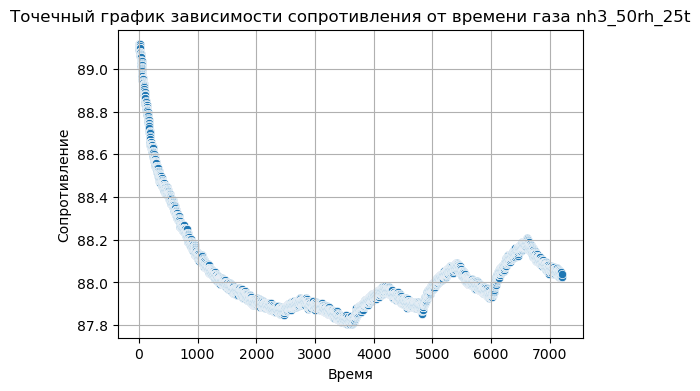

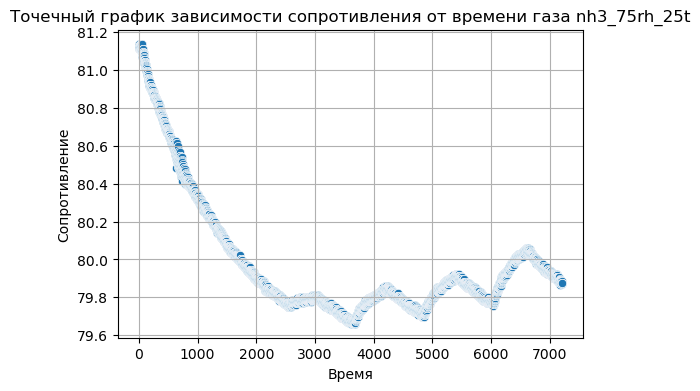

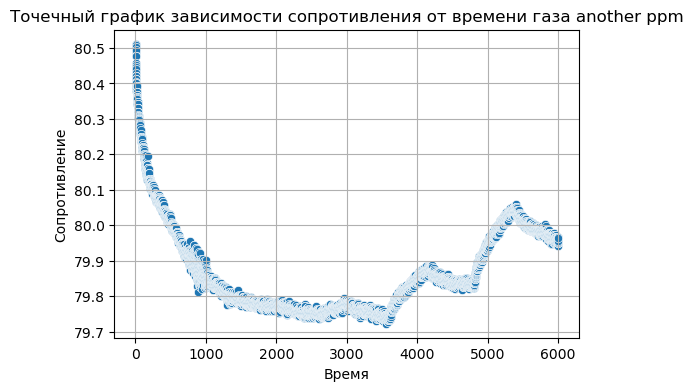

In [238]:
#графики NH3 при одинаковой температуре и разной влажности
nh3_2rh_25t_graph= dependency_graphs(nh3_2rh_25t, title = 'nh3_2rh_25t')
nh3_25rh_25t_graph = dependency_graphs(nh3_25rh_25t, title = 'nh3_25rh_25t')
nh3_50rh_25t_graph = dependency_graphs(nh3_50rh_25t, title = 'nh3_50rh_25t')
nh3_75rh_25t_graph = dependency_graphs(nh3_75rh_25t, title = 'nh3_75rh_25t')

nh3_2rh_25t_another_ppm_graph = dependency_graphs(nh3_2rh_25t_another_ppm, title='another ppm')

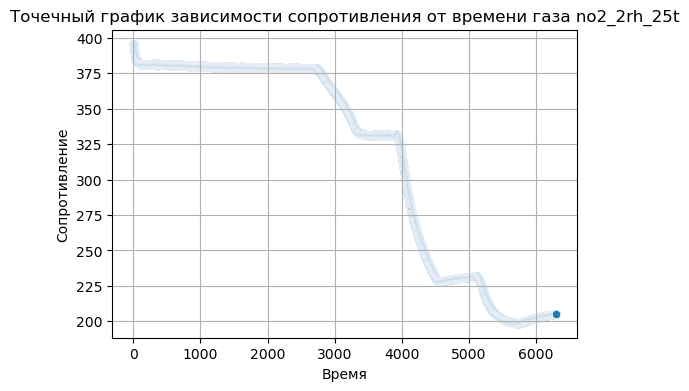

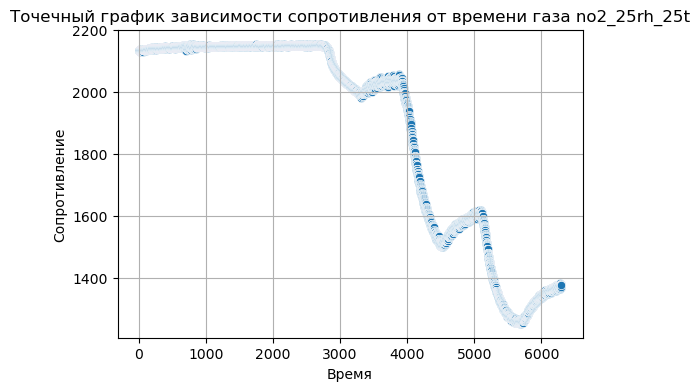

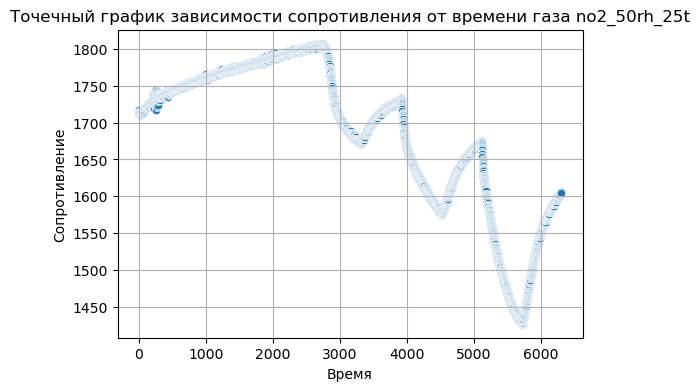

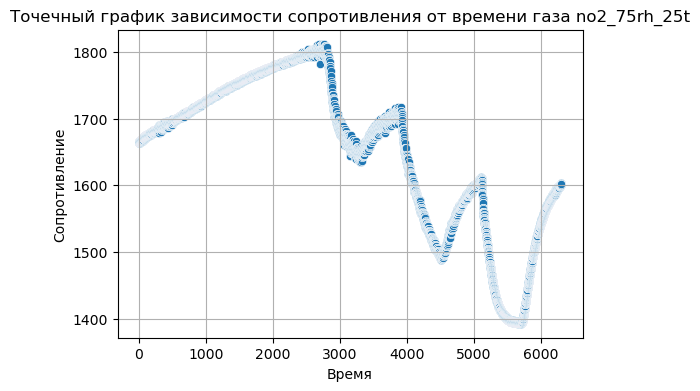

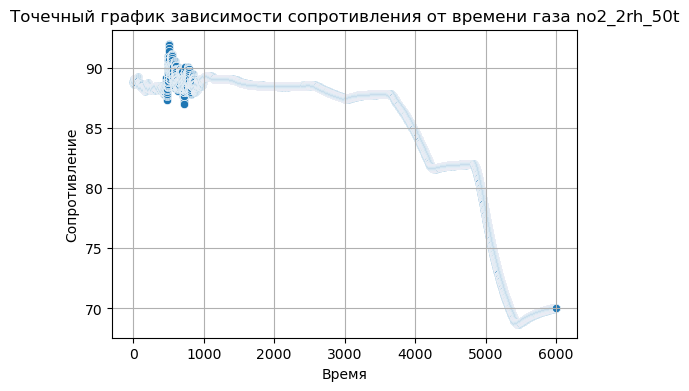

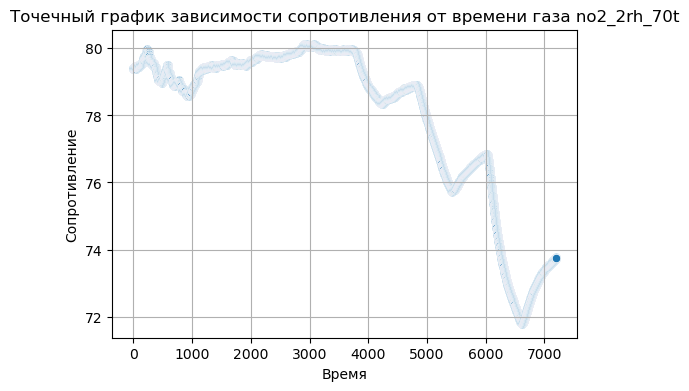

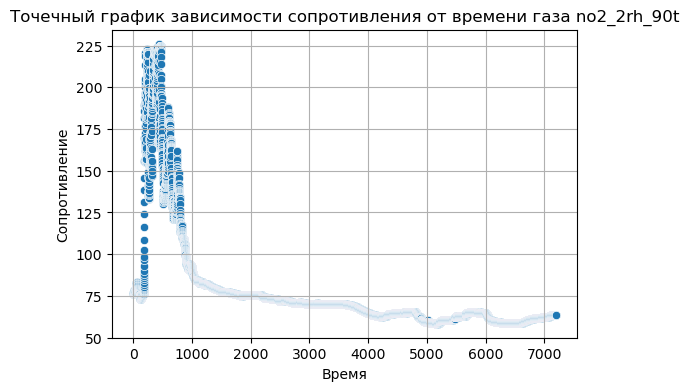

In [239]:
#графики NO2 при одинаковой температуре и разной влажности
no2_2rh_25t_graph = dependency_graphs(no2_2rh_25t, title = 'no2_2rh_25t')
no2_25rh_25t_graph = dependency_graphs(no2_25rh_25t, title = 'no2_25rh_25t')
no2_50rh_25t_graph = dependency_graphs(no2_50rh_25t, title = 'no2_50rh_25t')
no2_75rh_25t_graph = dependency_graphs(no2_75rh_25t, title='no2_75rh_25t')

#графики NO2 при температуре 50t
no2_2rh_50t_graph = dependency_graphs(no2_2rh_50t, title = 'no2_2rh_50t')

#графики NO2 при температуре 70t
no2_2rh_70t_graph = dependency_graphs(no2_2rh_70t,title='no2_2rh_70t')

#графики NO2 при температуре 90t
no2_2rh_90t_graph = dependency_graphs(no2_2rh_90t, title = 'no2_2rh_90t')

In [240]:
nh3_2rh_25t = nh3_2rh_25t.iloc[1:]
nh3_2rh_25t = nh3_2rh_25t.reset_index(drop=True)

nh3_25rh_25t = nh3_25rh_25t.iloc[1:]
nh3_25rh_25t = nh3_25rh_25t.reset_index(drop=True)

nh3_50rh_25t = nh3_50rh_25t.iloc[1:]
nh3_50rh_25t = nh3_50rh_25t.reset_index(drop=True)

nh3_75rh_25t = nh3_75rh_25t.iloc[1:]
nh3_75rh_25t = nh3_75rh_25t.reset_index(drop=True)

nh3_2rh_25t_another_ppm = nh3_2rh_25t_another_ppm.iloc[1:]
nh3_2rh_25t_another_ppm = nh3_2rh_25t_another_ppm.reset_index(drop=True)


no2_2rh_25t = no2_2rh_25t.iloc[1:]
no2_2rh_25t = no2_2rh_25t.reset_index(drop=True)

no2_25rh_25t = no2_25rh_25t.iloc[1:]
no2_25rh_25t = no2_25rh_25t.reset_index(drop=True)

no2_50rh_25t = no2_50rh_25t.iloc[1:]
no2_50rh_25t = no2_50rh_25t.reset_index(drop=True)

no2_75rh_25t = no2_75rh_25t.iloc[1:]
no2_75rh_25t = no2_75rh_25t.reset_index(drop=True)


no2_2rh_50t = no2_2rh_50t.iloc[1:]
no2_2rh_50t = no2_2rh_50t.reset_index(drop=True)

no2_2rh_70t = no2_2rh_70t.iloc[1:]
no2_2rh_70t = no2_2rh_70t.reset_index(drop=True)

no2_2rh_90t = no2_2rh_90t.iloc[1:]
no2_2rh_90t = no2_2rh_90t.reset_index(drop=True)
#nh3_2rh_25t

In [241]:
nh3_2rh_25t

,R [Ом],Time [с]
0,1916.370361,0.5
1,1917.799194,1.0
2,1914.129395,1.5
3,1916.431519,2.0
4,1915.614380,2.5
...,...,...
12594,1980.580811,6300.0
12595,1982.384766,6300.5
12596,1980.985718,6301.0
12597,1981.931763,6301.5


## Выявление тренда

Попробуем так: сначала усредним все точки, а потом найдем точки изменения тренда

Итак, мы усреднили наши данные, теперь попробуем использовать критерий Чоя, для того, чтобы он точно подтвердил, что предположительная точка смены тренда именно та, которая есть

## ПРОБУЕМ НОВЫЙ ПОДХОД

Что если наш усредненный массив мы будем делить на несколько частей, можем даже рассматривать не весь набор данных, а, например, первые 6000 строк(3000с). Этот набор данных разделим на несколько частей, допустим, на 6, в каждой части будем искать минимум(максимум), и затем будем сравнивать между собой разность значений минимумов(максимумов) среди последовательных промежутков. Чем больше окажется разность по модулю, значит, вероятно, смена тренда находится именно там, в минимуме(максимуме) прмоежутка слева.


Либо можно попробовать сделать так - разница между средними значениями наибольшая по модулю. И соответственно потом ищется минимум(максимум) в соответствующем предыдущем отрезке, вероятно, он и будет считаться точкой смены тренда

## И вновь обновление - новый подход в поиске глобального минимума или максимума, попробуем новые способы анализа временного ряда, обо всем этом дальше

1) Недавно я узнала о такой штуке как STL, попробуем ее


Но сначала закомментируем все, что тут появляется еще

In [242]:
def find_extremum_based_on_trend(df, value_col='R [Ом]', time_col='Time [с]', 
                                 smooth=True, window_size=51, polynomial_order=3, 
                                 trend_portion=0.1, use_regression=False, plot=True, gas_name = 'gas'):
    """
    Определяет направление тренда и находит соответствующий экстремум:
    Для восходящего тренда: индекс глобального минимума
    Для нисходящего тренда: индекс глобального максимума
    Также рисует график с исходными данными, сглаженными данными и найденным экстремумом
    Args:df Фрейм с данными (столбцы времени и значений)
        value_col: Название столбца с данными
        time_col: Название столбца с временем
        smooth: По стандарту стоит True, если нужно сглаживать данные
        window_size Размер окна для сглаживания (должен быть нечетным)
        polynomial_orde: Порядок полинома для сглаживания
        trend_portion: Доля данных (в процентах от начала и конца), используемых для определения тренда
        use_regression: Если True, использует линейную регрессию для определения тренда
        plot: Если True, рисует график с исходными, сглаженными данными и экстремумом
        gas_name: Название газа

    Returns:
        dict: Словарь с информацией о найденном экстремуме:
              - 'trend': 'восходящий' или 'нисходящий'
              - 'extremum_type': 'max' или 'min'
              - 'time': время, соответствующее экстремуму
              - 'value': значение экстремума
              - 'index': индекс экстремума в DataFrame
    """
    # Проверка входных данных
    if not isinstance(df, pd.DataFrame):
        raise TypeError("Входные данные должны быть DataFrame.")
    if value_col not in df.columns or time_col not in df.columns:
        raise ValueError(f"DataFrame должен содержать столбцы '{value_col}' и '{time_col}'.")

    # Извлекаем данные
    time = df[time_col].to_numpy()
    values = df[value_col].to_numpy()
    indices = np.arange(len(values))

    # Сохраняем исходные данные для графика
    original_values = values.copy()

    # Сглаживание данных
    if smooth:
        if window_size % 2 == 0:
            raise ValueError("Размер окна должен быть нечетным.")
        if window_size > len(values):
            raise ValueError("Размер окна не может быть больше длины данных.")
        values = savgol_filter(values, window_size, polynomial_order)

    # Определяем тренд
    if use_regression:
        # Используем линейную регрессию для определения наклона
        X = np.arange(len(values)).reshape(-1, 1)
        y = values
        model = LinearRegression()
        model.fit(X, y)
        slope = model.coef_[0]
        trend = 'ascending' if slope > 0 else 'descending'
    else:
        # Сравниваем средние значения в начале и конце
        n = len(values)
        portion_size = int(n * trend_portion)
        if portion_size < 1:
            portion_size = 1

        start_mean = np.mean(values[:portion_size])
        end_mean = np.mean(values[-portion_size:])
        trend = 'ascending' if end_mean > start_mean else 'descending'

    # Определяем тип экстремума
    extremum_type = 'max' if trend == 'ascending' else 'min'

    # Находим экстремум
    if extremum_type == 'min':
        extremum_idx = np.argmax(values)
    else:  # 'min'
        extremum_idx = np.argmin(values)

    # Получаем время, значение и индекс
    extremum_time = time[extremum_idx]
    extremum_value = values[extremum_idx]
    original_idx = indices[extremum_idx]

    # Отрисовка графика
    if plot:
        plt.figure(figsize=(12, 6))
        
        # Исходные данные
        plt.plot(time, original_values, label='Исходные данные', alpha=0.5, color='blue')
        
        # Сглаженные данные
        plt.plot(time, values, label='Сглаженные данные', color='orange', linewidth=2)
        
        # Вертикальная линия для экстремума
        plt.axvline(x=extremum_time, color='red', linestyle='--', label=f'{extremum_type} (индекс: {original_idx})')
        plt.scatter(extremum_time, extremum_value, color='red', zorder=5)

        # Настройки графика
        plt.title(f'Поиск экстремума на основе тренда (тренд: {trend}), газ {gas_name}')
        plt.xlabel('Время (с)')
        plt.ylabel('Сопротивление (Ом)')
        plt.legend()
        plt.grid(True)
        plt.show()

    # return {
    #     'trend': trend,
    #     'extremum_type': extremum_type,
    #     'time': extremum_time,
    #     'value': extremum_value,
    #     'index': original_idx
    # }
    return original_idx

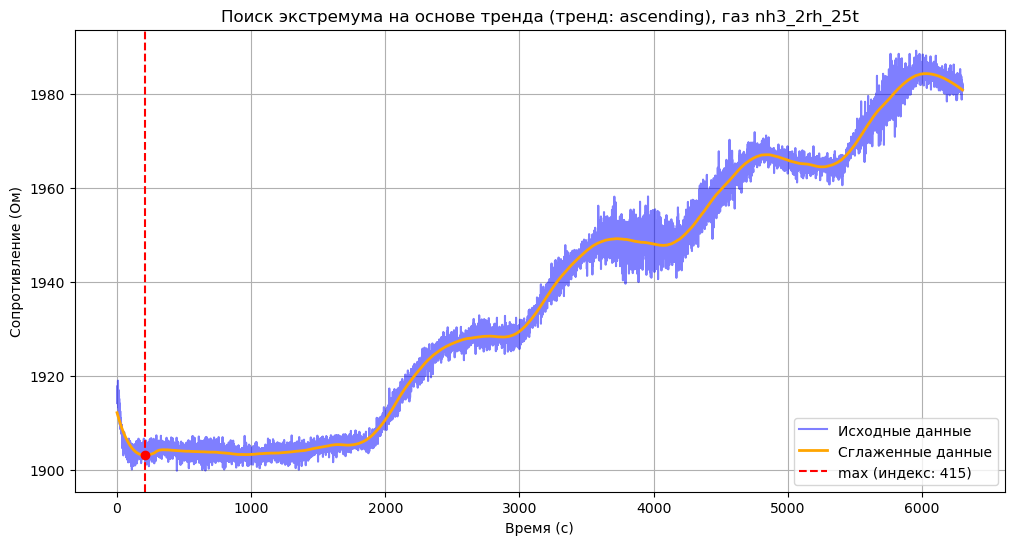

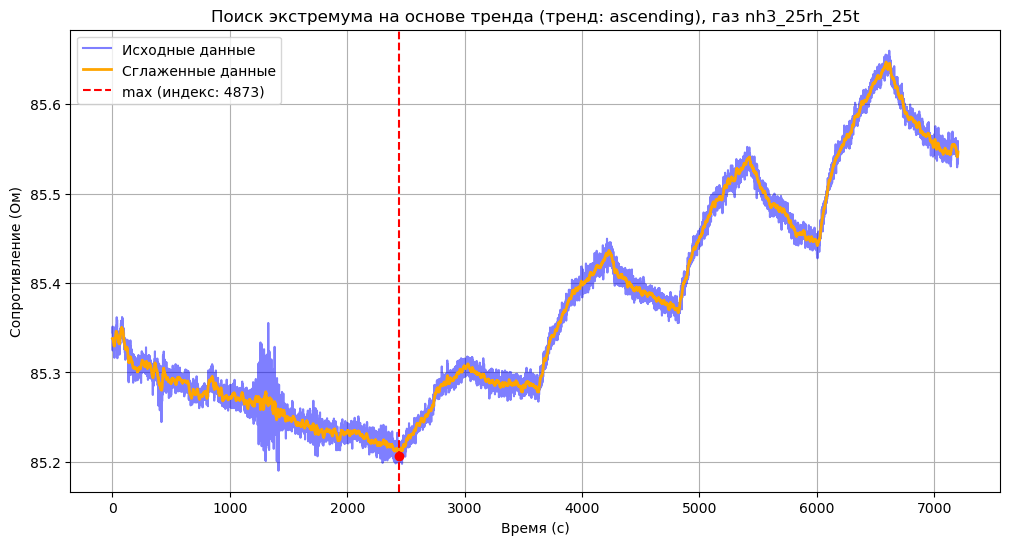

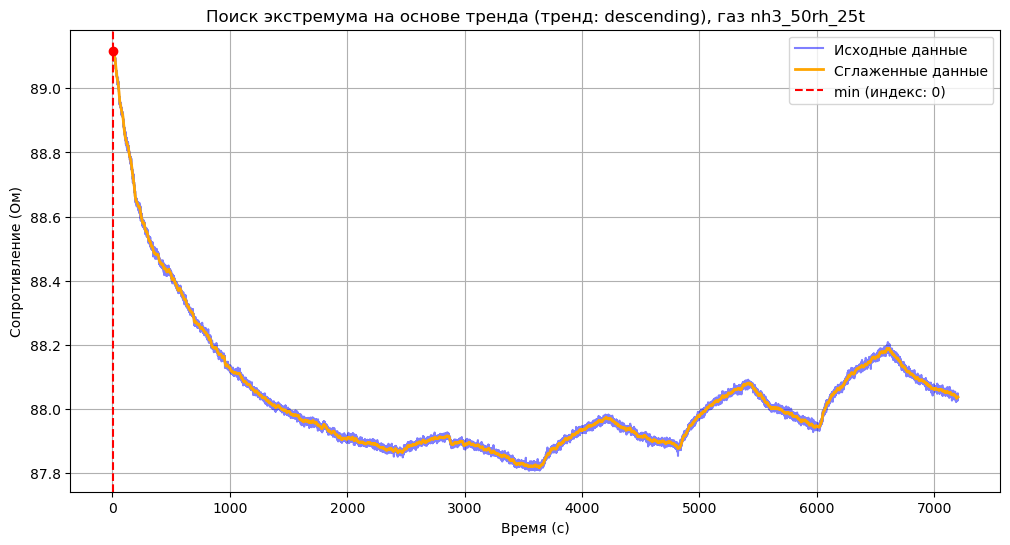

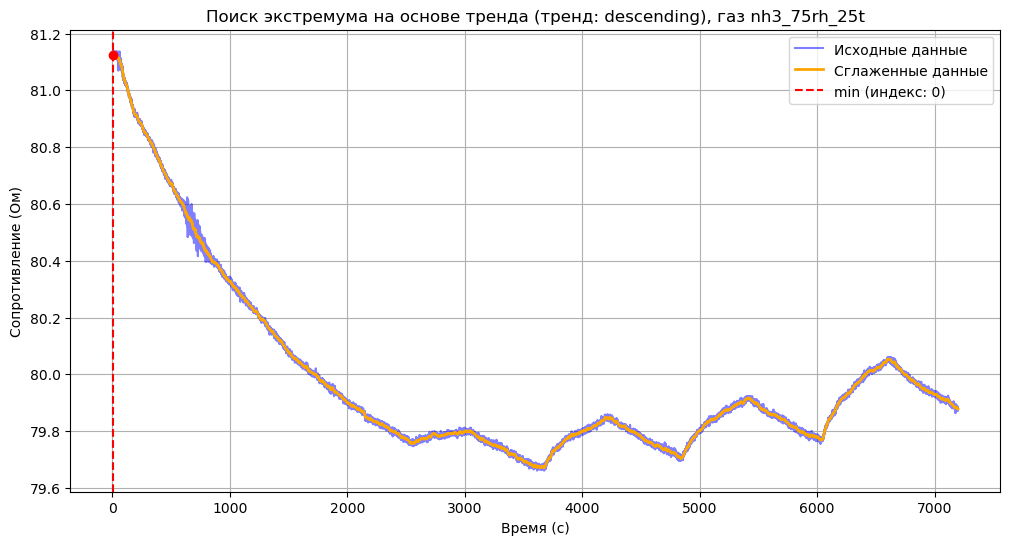

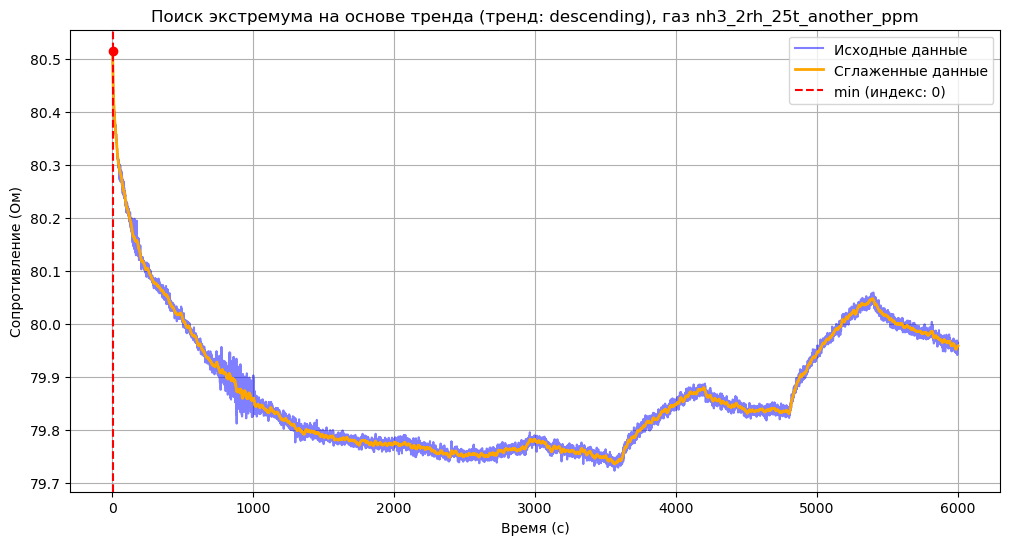

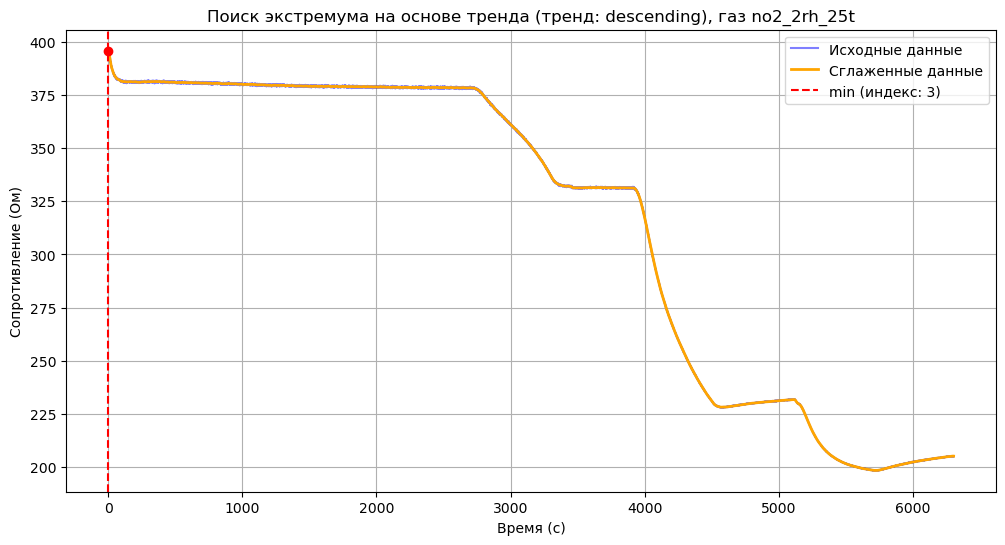

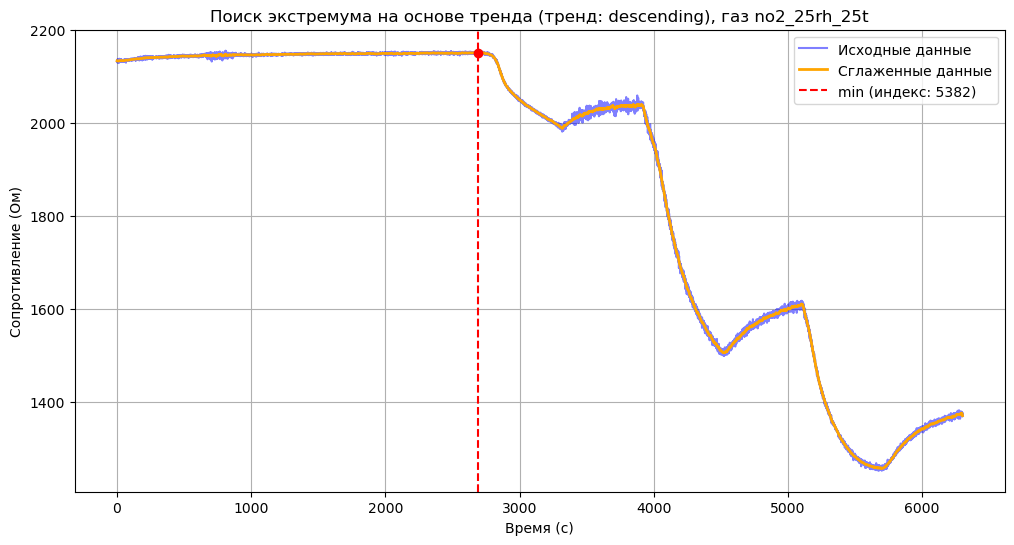

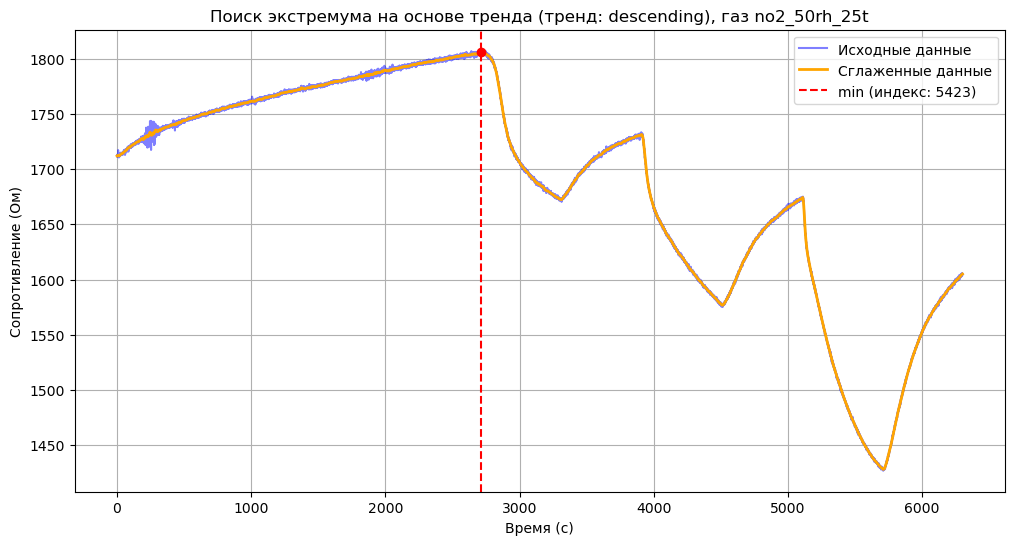

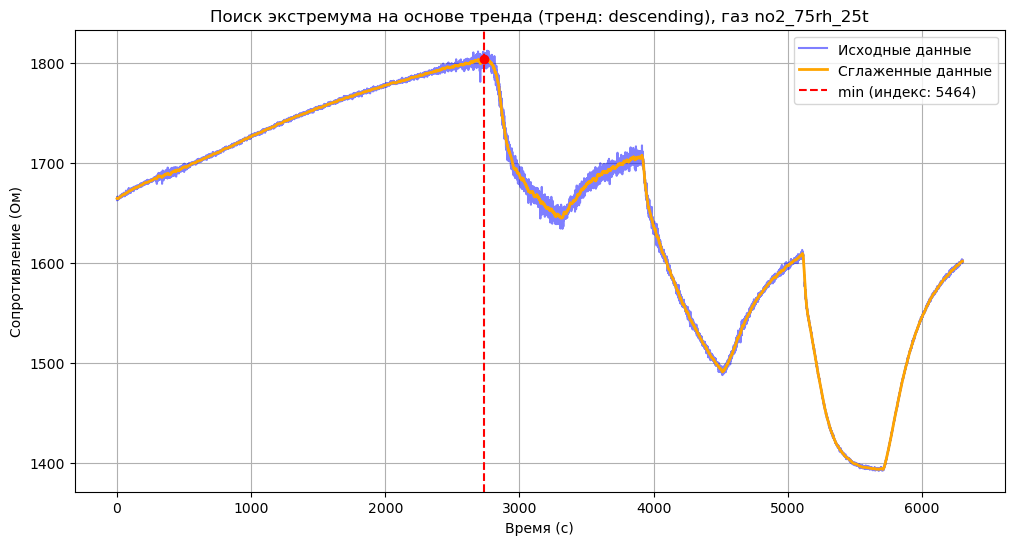

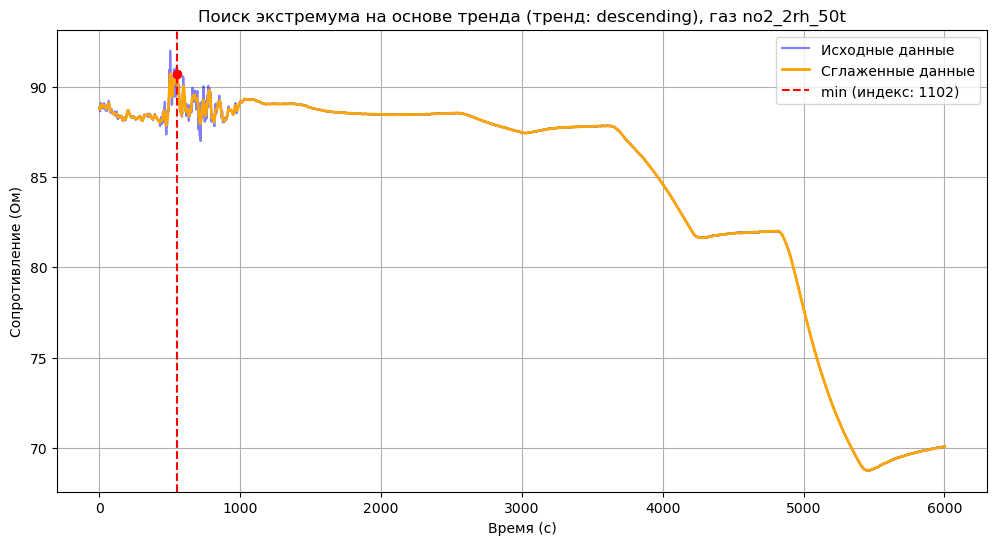

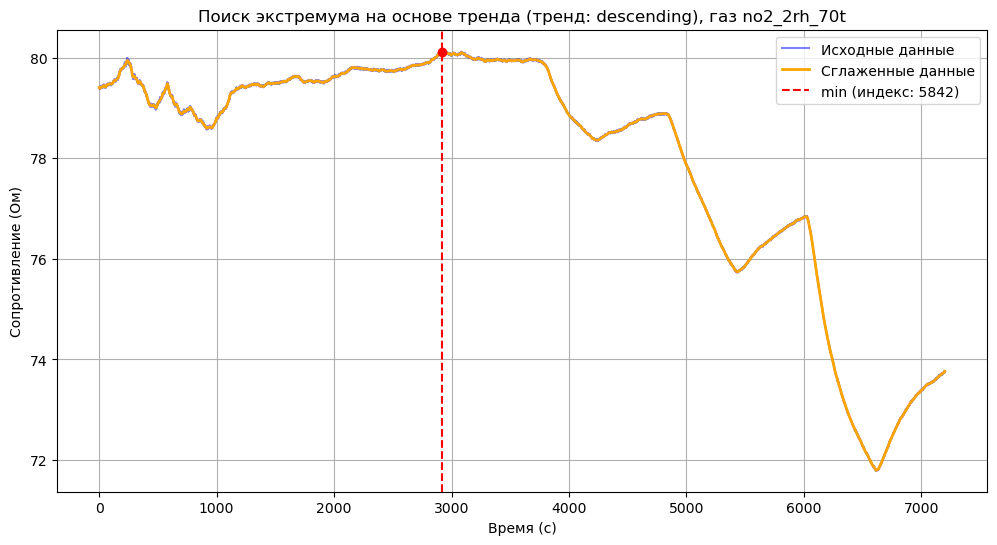

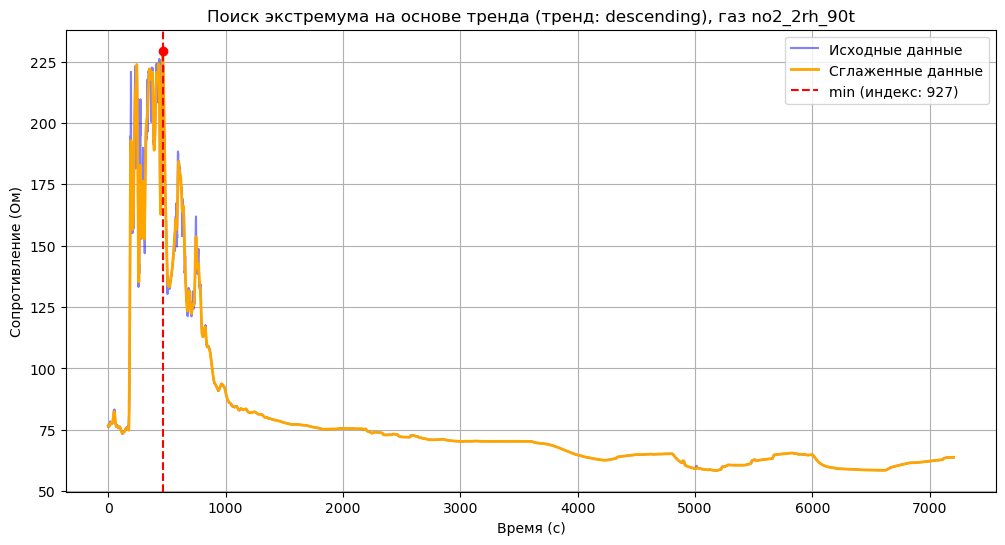

In [243]:
#NH3
trend_point_nh3_2rh_25t = find_extremum_based_on_trend(nh3_2rh_25t, value_col='R [Ом]',time_col='Time [с]',
                                                       smooth=True, window_size=1101, polynomial_order=3, use_regression=False, gas_name='nh3_2rh_25t')

trend_point_nh3_25rh_25t = find_extremum_based_on_trend(nh3_25rh_25t, value_col='R [Ом]',time_col='Time [с]',gas_name='nh3_25rh_25t')

trend_point_nh3_50rh_25t = find_extremum_based_on_trend(nh3_50rh_25t, value_col='R [Ом]',time_col='Time [с]', gas_name='nh3_50rh_25t')
trend_point_nh3_75rh_25t = find_extremum_based_on_trend(nh3_75rh_25t, value_col='R [Ом]',time_col='Time [с]', gas_name='nh3_75rh_25t')

trend_point_nh3_2rh_25t_another_ppm = find_extremum_based_on_trend(nh3_2rh_25t_another_ppm, value_col='R [Ом]',time_col='Time [с]',gas_name='nh3_2rh_25t_another_ppm')


#NO2 temp = 25
trend_point_no2_2rh_25t = find_extremum_based_on_trend(no2_2rh_25t, value_col='R [Ом]',time_col='Time [с]', gas_name='no2_2rh_25t')
trend_point_no2_25rh_25t = find_extremum_based_on_trend(no2_25rh_25t, value_col='R [Ом]',time_col='Time [с]', gas_name='no2_25rh_25t')
trend_point_no2_50rh_25t = find_extremum_based_on_trend(no2_50rh_25t, value_col='R [Ом]',time_col='Time [с]', gas_name='no2_50rh_25t')
trend_point_no2_75rh_25t = find_extremum_based_on_trend(no2_75rh_25t, value_col='R [Ом]',time_col='Time [с]', gas_name='no2_75rh_25t')

#NO2 temp = 50
trend_point_no2_2rh_50t = find_extremum_based_on_trend(no2_2rh_50t, value_col='R [Ом]',time_col='Time [с]', gas_name='no2_2rh_50t')

#NO2 temp = 70
trend_point_no2_2rh_70t = find_extremum_based_on_trend(no2_2rh_70t, value_col='R [Ом]',time_col='Time [с]', gas_name='no2_2rh_70t')

#NO2 temp = 90
trend_point_no2_2rh_90t = find_extremum_based_on_trend(no2_2rh_90t, value_col='R [Ом]',time_col='Time [с]', gas_name='no2_2rh_90t')

Пока что решение идет такое, надо придумать, как его исправить, но пока добавим обработку того, является ли наша точка точкой смена тренда с помощью критерия Чоу

In [244]:
def chow_test(df, breakpoint_index):
  """
  Выполняет тест Чоу для проверки изменения структурных параметров в точке перегиба временного ряда

  Args: df: фрейм с двумя столбцами: сопротивление и время
      breakpoint_index: Индекс строки, где предположительно происходит смена тренда.
  Returns: True, если тест Чоу отвергает гипотезу об отсутствии изменений, False в противном случае.
  """

  ########### Проверка входных данных###############
  if not isinstance(df, pd.DataFrame):
    raise TypeError("Входной фрем должен быть экземпляром pandas.DataFrame")
  if df.shape[1] != 2:
    raise ValueError("Датафрейм должен содержать два столбца: сопротивление и время.")
  if not all(col in df.columns for col in ["R [Ом]", "Time [с]"]):
    raise ValueError("DataFrame должен содержать столбцы с именами 'R [Ом]' и 'Time [с]'.")
  ##########################################################################################


  # Разделение данных на две части: до и после точки перегиба
  df_before = df.iloc[:breakpoint_index]
  df_after = df.iloc[breakpoint_index:]

  # Линейная регрессия до точки перегиба
  X_before = df_before["Time [с]"].values.reshape(-1, 1)
  y_before = df_before["R [Ом]"].values
  model_before = np.linalg.lstsq(X_before, y_before, rcond=None)
  residuals_before = y_before - X_before.dot(model_before[0])
  rss_before = np.sum(residuals_before**2)

  # Линейная регрессия после точки перегиба
  X_after = df_after["Time [с]"].values.reshape(-1, 1)
  y_after = df_after["R [Ом]"].values
  model_after = np.linalg.lstsq(X_after, y_after, rcond=None)
  residuals_after = y_after - X_after.dot(model_after[0])
  rss_after = np.sum(residuals_after**2)

  # Линейная регрессия на всех данных
  X_all = df["Time [с]"].values.reshape(-1, 1)
  y_all = df["R [Ом]"].values
  model_all = np.linalg.lstsq(X_all, y_all, rcond=None)
  residuals_all = y_all - X_all.dot(model_all[0])
  rss_all = np.sum(residuals_all**2)

  # Вычисление статистики Чоу
  k = 2  # Количество параметров в каждой модели (наклон и сдвиг)
  n1 = len(df_before)
  n2 = len(df_after)
  n = len(df)

  chow_statistic = ((rss_all - (rss_before + rss_after)) / k) / ((rss_before + rss_after) / (n - 2 * k))

  # Вычисление p-value
  p_value = 1 - stats.f.cdf(chow_statistic, k, n - 2 * k)

  # Определение, является ли точка точкой смены тренда
  alpha = 0.05  # Уровень значимости
  return p_value < alpha



In [245]:
#NH3
nh3_2rh_25t_is_breakpoint = chow_test(nh3_2rh_25t, trend_point_nh3_2rh_25t)
nh3_25rh_25t_is_breakpoint = chow_test(nh3_25rh_25t, trend_point_nh3_25rh_25t)
nh3_50rh_25t_is_breakpoint = chow_test(nh3_50rh_25t, trend_point_nh3_50rh_25t)
nh3_75rh_25t_is_breakpoint = chow_test(nh3_75rh_25t, trend_point_nh3_75rh_25t)

nh3_2rh_25t_is_breakpoint_another_ppm = chow_test(nh3_2rh_25t_another_ppm, trend_point_nh3_2rh_25t_another_ppm)

#NO2 temp=25
no2_2rh_25t_is_breakpoint = chow_test(no2_2rh_25t, trend_point_no2_2rh_25t)
no2_25rh_25t_is_breakpoint = chow_test(no2_25rh_25t, trend_point_no2_25rh_25t)
no2_50rh_25t_is_breakpoint = chow_test(no2_50rh_25t, trend_point_no2_50rh_25t)
no2_75rh_25t_is_breakpoint = chow_test(no2_75rh_25t, trend_point_no2_75rh_25t)

#NO2 temp = 50
no2_2rh_50t_is_breakpoint = chow_test(no2_2rh_50t, trend_point_no2_2rh_50t)

#NO2 temp = 70
no2_2rh_70t_is_breakpoint = chow_test(no2_2rh_70t, trend_point_no2_2rh_70t)

#NO2 temp = 90
no2_2rh_90t_is_breakpoint = chow_test(no2_2rh_90t, trend_point_no2_2rh_90t)

In [246]:
#NH3
print(f'Точка с индексом {trend_point_nh3_2rh_25t} является точко смены тренда для nh3_2rh_25t? - {nh3_2rh_25t_is_breakpoint}')
print(f'Точка с индексом {trend_point_nh3_25rh_25t} является точко смены тренда для nh3_25rh_25t? - {nh3_25rh_25t_is_breakpoint}')
print(f'Точка с индексом {trend_point_nh3_50rh_25t} является точко смены тренда для nh3_50rh_25t? - {nh3_50rh_25t_is_breakpoint}')
print(f'Точка с индексом {trend_point_nh3_75rh_25t} является точко смены тренда для nh3_75rh_25t? - {nh3_75rh_25t_is_breakpoint}')

print(f'Точка с индексом {trend_point_nh3_2rh_25t_another_ppm} является точко смены тренда для nh3_2rh_25t_another_ppm? - {nh3_2rh_25t_is_breakpoint_another_ppm}')

#NO2 temp=25
print(f'Точка с индексом {trend_point_no2_2rh_25t} является точко смены тренда для no2_2rh_25t? - {no2_2rh_25t_is_breakpoint}')
print(f'Точка с индексом {trend_point_no2_25rh_25t} является точко смены тренда для no2_25rh_25t? - {no2_25rh_25t_is_breakpoint}')
print(f'Точка с индексом {trend_point_no2_50rh_25t} является точко смены тренда для no2_50rh_25t? - {no2_50rh_25t_is_breakpoint}')
print(f'Точка с индексом {trend_point_no2_75rh_25t} является точко смены тренда для no2_75rh_25t? - {no2_75rh_25t_is_breakpoint}')

#NO2 temp=50
print(f'Точка с индексом {trend_point_no2_2rh_50t} является точко смены тренда для no2_2rh_50t? - {no2_2rh_50t_is_breakpoint}')

#NO2 temp = 70
print(f'Точка с индексом {trend_point_no2_2rh_70t} является точко смены тренда для no2_2rh_70t? - {no2_2rh_70t_is_breakpoint}')

#NO2 temp=90
print(f'Точка с индексом {trend_point_no2_2rh_90t} является точко смены тренда для no2_2rh_90t? - {no2_2rh_90t_is_breakpoint}')

Точка с индексом 415 является точко смены тренда для nh3_2rh_25t? - True
Точка с индексом 4873 является точко смены тренда для nh3_25rh_25t? - True
Точка с индексом 0 является точко смены тренда для nh3_50rh_25t? - False
Точка с индексом 0 является точко смены тренда для nh3_75rh_25t? - False
Точка с индексом 0 является точко смены тренда для nh3_2rh_25t_another_ppm? - False
Точка с индексом 3 является точко смены тренда для no2_2rh_25t? - True
Точка с индексом 5382 является точко смены тренда для no2_25rh_25t? - True
Точка с индексом 5423 является точко смены тренда для no2_50rh_25t? - True
Точка с индексом 5464 является точко смены тренда для no2_75rh_25t? - True
Точка с индексом 1102 является точко смены тренда для no2_2rh_50t? - True
Точка с индексом 5842 является точко смены тренда для no2_2rh_70t? - True
Точка с индексом 927 является точко смены тренда для no2_2rh_90t? - True


Дальше можно прописать это для всех наборов файлов

In [247]:
nh3_2rh_25t = nh3_2rh_25t.iloc[415:]
nh3_25rh_25t = nh3_25rh_25t.iloc[4873:]
nh3_50rh_25t = nh3_50rh_25t.iloc[7032:]#Не совсем правильно определяется
nh3_75rh_25t = nh3_75rh_25t.iloc[7093:]#Не совсем правильно определяется

nh3_2rh_25t_another_ppm = nh3_2rh_25t_another_ppm.iloc[6761:]#Не совсем правильно определяется


no2_2rh_25t = no2_2rh_25t.iloc[3:]
no2_25rh_25t = no2_25rh_25t.iloc[5382:]
no2_50rh_25t = no2_50rh_25t.iloc[5423:]
no2_75rh_25t = no2_75rh_25t.iloc[5464:]

no2_2rh_50t = no2_2rh_50t.iloc[1102:]

no2_2rh_70t = no2_2rh_70t.iloc[5842:]

no2_2rh_90t = no2_2rh_90t.iloc[927:]

no2_2rh_90t

,Time [с],R [Ом]
927,464.5,224.162766
928,465.0,223.600815
929,465.5,223.698318
930,466.0,224.041931
931,466.5,223.392319
...,...,...
14394,7200.5,63.783108
14395,7201.0,63.795902
14396,7201.5,63.803734
14397,7202.0,63.795231


Тут я задумалась, а дальше стоит генерировать просто обрезанные на такую длину датафреймы? Или лучше брать усредненную линию? В общем, сейчас попробуем с просто обрезанными датафреймами.<p>
Также что я еще заметила и подумала: для чего же искать эту точку смены тренда? Возможно, таким образом будет удобнее подавать в сеть и она будет лучше предсказывать. А может, потом в принципе придется менять подход? Или с помощью этого можно так скажем +- определить через какое же время "прибор" сможет начать предсказание? Так скажем чтобы точно не спутать
<br>
<br>
P.s. пишу ночью 07.02.2025

Ну, в общем-то, после обрезки вернемся к нашим собакам

## Дальнейшее преобразование

In [248]:
#функция для обработки - добавим отдельный столбик с температурой, с относительнеой влажностью(для каждого файла она своя, но постоянная)
def temperature_and_RH(df,t,rh):
    df['temperature[°C]'] = t
    df['RH[%]']=rh
    return df

#NH3 temp = 25s
nh3_2rh_25t = temperature_and_RH(nh3_2rh_25t,25,2)
nh3_25rh_25t = temperature_and_RH(nh3_2rh_25t,25,25)
nh3_50rh_25t = temperature_and_RH(nh3_50rh_25t,25,50)
nh3_75rh_25t = temperature_and_RH(nh3_75rh_25t,25,75)
nh3_2rh_25t_another_ppm = temperature_and_RH(nh3_2rh_25t_another_ppm,25,2)

#NO2 temp = 25
no2_2rh_25t = temperature_and_RH(no2_2rh_25t,25,2)
no2_25rh_25t = temperature_and_RH(no2_25rh_25t,25,25)
no2_50rh_25t = temperature_and_RH(no2_50rh_25t,25,50)
no2_75rh_25t = temperature_and_RH(no2_75rh_25t,25,75)

#NO2 temp = 50
no2_2rh_50t = temperature_and_RH(no2_2rh_50t,50,2)

#NO2 temp = 75
no2_2rh_70t = temperature_and_RH(no2_2rh_70t,70,2)

#NO2 temp = 90
no2_2rh_90t = temperature_and_RH(no2_2rh_90t,90,2)

#вывод
nh3_50rh_25t

C:\Users\katya\AppData\Local\Temp\ipykernel_2888\1395315236.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['temperature[°C]'] = t
C:\Users\katya\AppData\Local\Temp\ipykernel_2888\1395315236.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['RH[%]']=rh
C:\Users\katya\AppData\Local\Temp\ipykernel_2888\1395315236.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

,R [Ом],Time [с],temperature[°C],RH[%]
7032,87.833260,3518.0,25,50
7033,87.821846,3518.5,25,50
7034,87.829300,3519.0,25,50
7035,87.818947,3519.5,25,50
7036,87.827225,3520.0,25,50
...,...,...,...,...
14393,88.048531,7200.0,25,50
14394,88.035156,7200.5,25,50
14395,88.036003,7201.0,25,50
14396,88.027138,7201.5,25,50


In [249]:
# #ЗДЕСЬ ВОЗНИКАЮТ НАНЫ, избавление он nan'ов происходит ниже
# #ДОСТАТОЧНО МНОГО НУЛЕЙ ПОЯВЛЯЕТСЯ В СТОЛБЦЕ ПЕРИОДА 
# #функция для вычисления sin_time и cos_time

def sin_time_and_cos_time(df, time_column,R_column):
    df['period'] = df[R_column].diff()
    #print((df['period'] == 0).sum())
    #чтобы не появлялось нанов в столбцах с косинусом и синусом
    df.dropna(subset=['period'], inplace=True)

    df['sin_time'] = np.sin(2 * np.pi * df[time_column] / df['period'])
    df['cos_time'] = np.cos(2 * np.pi * df[time_column] / df['period'])
#удаляем временный столбец 'period'
    df.drop('period', axis=1, inplace=True)
    return df

#NH3 temp = 25
nh3_2rh_25t = sin_time_and_cos_time(nh3_2rh_25t,'Time [с]','R [Ом]')
nh3_25rh_25t = sin_time_and_cos_time(nh3_25rh_25t,'Time [с]','R [Ом]')
nh3_50rh_25t = sin_time_and_cos_time(nh3_50rh_25t,'Time [с]','R [Ом]')
nh3_75rh_25t = sin_time_and_cos_time(nh3_75rh_25t,'Time [с]','R [Ом]')
nh3_2rh_25t_another_ppm = sin_time_and_cos_time(nh3_2rh_25t_another_ppm, 'Time [с]','R [Ом]')

#NO2 temp = 25
no2_2rh_25t  = sin_time_and_cos_time(no2_2rh_25t,'Time [с]','R [Ом]')
no2_25rh_25t = sin_time_and_cos_time(no2_25rh_25t,'Time [с]','R [Ом]')
no2_50rh_25t = sin_time_and_cos_time(no2_50rh_25t,'Time [с]','R [Ом]')
no2_75rh_25t = sin_time_and_cos_time(no2_75rh_25t,'Time [с]','R [Ом]')

#NO2 temp = 50
no2_2rh_50t = sin_time_and_cos_time(no2_2rh_50t,'Time [с]','R [Ом]')

#NO2 temp = 70
no2_2rh_70t = sin_time_and_cos_time(no2_2rh_70t,'Time [с]','R [Ом]')

#NO2 temp = 90
no2_2rh_90t = sin_time_and_cos_time(no2_2rh_90t, 'Time [с]','R [Ом]')

#вывод
nh3_50rh_25t

C:\Users\katya\AppData\Local\Temp\ipykernel_2888\4023087237.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['period'] = df[R_column].diff()
C:\Users\katya\AppData\Local\Temp\ipykernel_2888\4023087237.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=['period'], inplace=True)
c:\Users\katya\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in sin
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\katya\AppData\Local\Temp\ipykernel_2888\4023087237.py:11: SettingWithCopyWarning: 


,R [Ом],Time [с],temperature[°C],RH[%],sin_time,cos_time
7033,87.821846,3518.5,25,50,-0.978031,-0.208459
7034,87.829300,3519.0,25,50,-0.914545,-0.404483
7035,87.818947,3519.5,25,50,0.724484,0.689292
7036,87.827225,3520.0,25,50,-0.144269,0.989539
7037,87.847458,3520.5,25,50,-0.573900,-0.818925
...,...,...,...,...,...,...
14393,88.048531,7200.0,25,50,-0.405654,0.914027
14394,88.035156,7200.5,25,50,-0.862116,0.506710
14395,88.036003,7201.0,25,50,0.605951,-0.795502
14396,88.027138,7201.5,25,50,-0.977277,-0.211965


In [250]:
#удаляем наны в датафрейме, а точнее заменяем их на предыдущее значение

#NH3 temp = 25
nh3_2rh_25t.fillna(method = "ffill", inplace=True)
nh3_25rh_25t.fillna(method = "ffill", inplace=True)
nh3_50rh_25t.fillna(method = "ffill", inplace=True)
nh3_75rh_25t.fillna(method = 'ffill', inplace=True)
nh3_2rh_25t_another_ppm.fillna(method='ffill', inplace=True)

#NO2 temp = 25
no2_2rh_25t.fillna(method='ffill', inplace=True)
no2_25rh_25t.fillna(method='ffill', inplace=True)
no2_50rh_25t.fillna(method='ffill', inplace=True)
no2_75rh_25t.fillna(method='ffill', inplace=True)

#NO2 temp = 50
no2_2rh_50t.fillna(method='ffill', inplace=True)

#NO2 temp = 75
no2_2rh_70t.fillna(method='ffill', inplace=True)

#NO2 temp = 90
no2_2rh_90t.fillna(method='ffill', inplace=True)

C:\Users\katya\AppData\Local\Temp\ipykernel_2888\1022477976.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  nh3_2rh_25t.fillna(method = "ffill", inplace=True)
C:\Users\katya\AppData\Local\Temp\ipykernel_2888\1022477976.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nh3_2rh_25t.fillna(method = "ffill", inplace=True)
C:\Users\katya\AppData\Local\Temp\ipykernel_2888\1022477976.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  nh3_25rh_25t.fillna(method = "ffill", inplace=True)
C:\Users\katya\AppData\Local\Temp\ipykernel_2888\1022477976.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

In [251]:
#проверка на отсутствие нанов

#NH3 temp = 25
nh3_2rh_25t.isnull().sum()
nh3_25rh_25t.isnull().sum()
# nh3_50rh_25t.isnull().sum()
# nh3_75rh_25t.isnull().sum()
nh3_2rh_25t_another_ppm.isnull().sum()

#NO2 temp = 25
no2_2rh_25t.isnull().sum()
no2_25rh_25t.isnull().sum()
no2_50rh_25t.isnull().sum()
no2_75rh_25t.isnull().sum()

#NO2 temp = 50
no2_2rh_50t.isnull().sum()

#NO2 temp = 70
no2_2rh_70t.isnull().sum()

#NO2 temp = 90
no2_2rh_90t.isnull().sum()

Time [с]           0
R [Ом]             0
temperature[°C]    0
RH[%]              0
sin_time           0
cos_time           0
dtype: int64

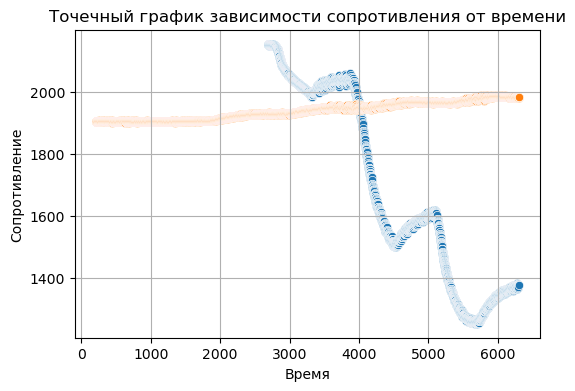

In [252]:
#проверим. что при нормализации ничего толком не поменялось, а также посмотрим на зависимость
def two_graphs(gas1, gas2):
    gas1 = gas1.iloc[1:]
    gas2 = gas2.iloc[1:]

    # Построим точечный график
    plt.figure(figsize=(6, 4))# размер графика
    sns.scatterplot(x='Time [с]', y='R [Ом]', data=gas1)# что и откуда берем
    sns.scatterplot(x='Time [с]', y='R [Ом]', data=gas2)

    plt.xlabel('Время')#ну как бы просто название
    plt.ylabel('Сопротивление')#название игрека
    plt.title('Точечный график зависимости сопротивления от времени')
    plt.grid(True)#добавим сеточку

    return plt.show()
dependency_graph = two_graphs(no2_25rh_25t, nh3_2rh_25t)#первый график - синий, второй - оранжевый

In [253]:
#целевая переменная
def target(df,value):
    df['y'] = value
    return df

#NH3 temp = 25
nh3_2rh_25t = target(nh3_2rh_25t,1)
nh3_25rh_25t = target(nh3_25rh_25t,1)
nh3_50rh_25t = target(nh3_50rh_25t,1)
nh3_75rh_25t = target(nh3_75rh_25t,1)
nh3_2rh_25t_another_ppm = target(nh3_2rh_25t_another_ppm,1)

#NO2 temp = 25
no2_2rh_25t = target(no2_2rh_25t,0)
no2_25rh_25t = target(no2_25rh_25t,0)
no2_50rh_25t = target(no2_50rh_25t,0)
no2_75rh_25t = target(no2_75rh_25t,0)

#NO2 temp = 50
no2_2rh_50t = target(no2_2rh_50t,0)

#NO2 temp = 70
no2_2rh_70t = target(no2_2rh_70t,0)

#NO2 temp = 90
no2_2rh_90t = target(no2_2rh_90t,0)
#вывод
no2_2rh_25t

C:\Users\katya\AppData\Local\Temp\ipykernel_2888\1088662633.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['y'] = value


,R [Ом],Time [с],temperature[°C],RH[%],sin_time,cos_time,y
4,395.259003,2.5,25,2,-0.995365,-0.096165,0
5,394.970032,3.0,25,2,-0.676877,-0.736096,0
6,395.373474,3.5,25,2,-0.891975,-0.452084,0
7,395.277313,4.0,25,2,0.572192,-0.820120,0
8,395.154083,4.5,25,2,0.107159,-0.994242,0
...,...,...,...,...,...,...,...
12594,205.186600,6300.0,25,2,-0.580102,0.814544,0
12595,205.107727,6300.5,25,2,0.561022,0.827801,0
12596,205.248077,6301.0,25,2,-0.958055,0.286585,0
12597,205.188324,6301.5,25,2,-0.575255,-0.817974,0


In [254]:
##############ДЛЯ ТРЭЙН ТЕСТА###########################
########ВНИМАНИЕ#####
#данные для обучения состоят только из конкатенации этих двух файлов
common_data = pd.concat([nh3_2rh_25t,
                         nh3_25rh_25t,
                         nh3_50rh_25t,
                         nh3_75rh_25t, 
                         nh3_2rh_25t_another_ppm, 
                         no2_2rh_25t, 
                         no2_25rh_25t,
                         no2_50rh_25t, 
                         no2_75rh_25t, 
                         no2_2rh_50t, 
                         no2_2rh_70t,
                         no2_2rh_90t,], ignore_index=True)

# Отделим целевую переменную в список
target_data = common_data['y'].tolist()

#теперь избавимся от столбца y
common_data_no_y = common_data.drop('y', axis = 1)

#Преобразуем теперь наши данные в список(для обучения надо так)
def dataframe_to_list_of_lists(df):
    """Преобразует датафрейм в список списков, где каждый внутренний список представляет строку датафрейма"""
    list_of_lists = []
    for _, row in df.iterrows():
        list_of_lists.append(row.tolist())
    return list_of_lists

X_data = dataframe_to_list_of_lists(common_data_no_y)
X_data

[[1901.853515625,
  209.0,
  25.0,
  25.0,
  -0.9990098471584218,
  -0.04448960868008041],
 [1904.6884765625, 209.5, 25.0, 25.0, -0.5942451000787458, 0.8042840052073654],
 [1901.671875, 210.0, 25.0, 25.0, 0.6601896897082162, -0.7510989106655456],
 [1903.111328125, 210.5, 25.0, 25.0, 0.9961843711986683, 0.08727369924274872],
 [1903.24609375, 211.0, 25.0, 25.0, -0.9079047553196034, -0.4191765204159831],
 [1902.96875, 211.5, 25.0, 25.0, 0.5440203984022746, -0.8390719910247454],
 [1902.3118896484375,
  212.0,
  25.0,
  25.0,
  0.9998711157572797,
  -0.016054652730363418],
 [1904.6085205078125,
  212.5,
  25.0,
  25.0,
  -0.16785309576644428,
  -0.9858120197287213],
 [1904.085205078125,
  213.0,
  25.0,
  25.0,
  -0.12716515947939225,
  0.9918815565452261],
 [1903.2457275390625,
  213.5,
  25.0,
  25.0,
  -0.8914312925063028,
  -0.453155879075338],
 [1903.2298583984375,
  214.0,
  25.0,
  25.0,
  -0.9648755533464777,
  -0.26270737818783957],
 [1902.8182373046875,
  214.5,
  25.0,
  25.0,
  

In [255]:
# Разделение на тренировочную и валидационную выборки
# в целом здесь можно конечно посмотреть и еще некоторые атрибуты, чтобы разделит удобно, но в целом
#итак неплохо 
X_train, X_val, y_train, y_val = train_test_split(X_data, target_data, test_size=0.2, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

print(f"Размер тренировочной выборки: {len(X_train)}")
print(f"Размер валидационной выборки: {len(X_val)}")
print(f"Размер тестовой выборки: {len(X_test)}")
class_0_count = 0
class_1_count = 0

for element in y_test:
    if element == 0:
        class_0_count += 1
    elif element == 1:
        class_1_count += 1

print(f"Количество элементов класса 0(диоксид азота): {class_0_count}")
print(f"Количество элементов класса 1(аммиак): {class_1_count}")


Размер тренировочной выборки: 89038
Размер валидационной выборки: 11130
Размер тестовой выборки: 11130
Количество элементов класса 0(диоксид азота): 6645
Количество элементов класса 1(аммиак): 4485


In [256]:
# Преобразование данных в тензоры PyTorch
x_train_tensor = torch.tensor(X_train, dtype=torch.float32)# из нумпая в тензор, данные как float32 
y_train_tensor = torch.tensor(y_train, dtype=torch.long) #long -  для классификации(указывает типа, что это прям переменные класса именно, а не просто признаки)


x_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)


# Модель RNN
class SimpleRNN(nn.Module):#базовый модуль для всех нейронок библиотеки
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()# конструктор из класса-родителя, для инициализации
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)#dim батча - первая размерность входного тензора
        self.fc = nn.Linear(hidden_size, output_size)#полностью связанный слой, используется для преобразования скрытого состояния в выходной вектор
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        #Создаем тензор нулей, начальное скрытое состояние (h0)
        #1: dim, соответствующая направлению RNN (в данном случае - 1, так как RNN не двунаправленный)
        #x.size(0): Размер батча (количество примеров в батче)
        #self.hidden_size: Размер скрытого состояния
        h0 = torch.zeros(1, x.size(0), self.hidden_size)# Инициализация hidden state, важное изменение для batch_first=True
        out, hn = self.rnn(x, h0) #hn - последнее скрытое состояние, out - выход rnn содержит скрытое состояние на каждом временном шаге
        out = self.fc(out[:, -1, :]) #все элементы батча, посл вр шаг, все знач скрыт. сост.
        out = self.sigmoid(out)
        return out

# Гиперпараметры
input_size = 6# количество элементов в каждом подмассиве нашего массива
hidden_size = 32# подбираем сами, такое количество вполне норм сейчас
output_size = 1# выходной слой
learning_rate = 0.01# размер шага для нашего алгоритма оптимизации
epochs = 500
batch_size = len(X_train)#соответствует длине данных, В ОБЩЕМ СЛУЧАЕ ЛУЧШЕ ЧУТЬ ПОДПРАВИТЬ ЭТО


model = SimpleRNN(input_size, hidden_size, output_size)
criterion = nn.BCELoss() # Бинарная кросс-энтропия
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Обучение
for epoch in range(epochs):
    optimizer.zero_grad()#сбрасываем градиенты оптимизатора до нуля, иначе с расчетом весов будет проблема
    outputs = model(x_train_tensor.unsqueeze(1)) # Добавляем дополнительную размерность для времени
    loss = criterion(outputs.squeeze(1), y_train_tensor.float()) # Снимаем лишнее измерение
    loss.backward()
    optimizer.step()#обновляем веса модели
    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            train_predictions = (model(x_train_tensor.unsqueeze(1)) > 0.5).float()
            train_accuracy = accuracy_score(y_train_tensor.numpy(), train_predictions.squeeze(1).numpy())

            # Оценка на валидационных данных
            val_predictions = (model(x_val_tensor.unsqueeze(1)) > 0.5).float()
            val_loss = criterion(val_predictions.squeeze(1), y_val_tensor.float())
            val_accuracy = accuracy_score(y_val_tensor.numpy(), val_predictions.squeeze(1).numpy())

            print(f'Epoch [{epoch+1}/{epochs}], '
                  f'Loss: {loss.item():.4f}, Accuracy: {train_accuracy:.4f}, '
                  f'Val Loss: {val_loss.item():.4f}, Val Accuracy: {val_accuracy:.4f}')


#Оценка точности после обучения
with torch.no_grad():
    predictions = (model(x_train_tensor.unsqueeze(1)) > 0.5).float()
    accuracy = accuracy_score(y_train_tensor.numpy(), predictions.squeeze(1).numpy())
    print(f'\nTrain Accuracy: {accuracy:.4f}')

with torch.no_grad():
    final_val_predictions = (model(x_val_tensor.unsqueeze(1)) > 0.5).float()
    final_val_accuracy = accuracy_score(y_val_tensor.numpy(), final_val_predictions.squeeze(1).numpy())
    print(f'\nValidation Accuracy: {final_val_accuracy:.4f}')


Epoch [10/500], Loss: 0.6356, Accuracy: 0.6787, Val Loss: 32.3989, Val Accuracy: 0.6760
Epoch [20/500], Loss: 0.6180, Accuracy: 0.6891, Val Loss: 31.6442, Val Accuracy: 0.6836
Epoch [30/500], Loss: 0.5985, Accuracy: 0.6843, Val Loss: 31.7610, Val Accuracy: 0.6824
Epoch [40/500], Loss: 0.5985, Accuracy: 0.6854, Val Loss: 31.5544, Val Accuracy: 0.6845
Epoch [50/500], Loss: 0.5996, Accuracy: 0.6845, Val Loss: 32.4349, Val Accuracy: 0.6757
Epoch [60/500], Loss: 0.5898, Accuracy: 0.7068, Val Loss: 29.9012, Val Accuracy: 0.7010
Epoch [70/500], Loss: 0.5860, Accuracy: 0.7086, Val Loss: 30.0719, Val Accuracy: 0.6993
Epoch [80/500], Loss: 0.5714, Accuracy: 0.7321, Val Loss: 27.4753, Val Accuracy: 0.7252
Epoch [90/500], Loss: 0.5615, Accuracy: 0.7426, Val Loss: 26.4870, Val Accuracy: 0.7351
Epoch [100/500], Loss: 0.5807, Accuracy: 0.7116, Val Loss: 29.4609, Val Accuracy: 0.7054
Epoch [110/500], Loss: 0.5917, Accuracy: 0.6955, Val Loss: 30.6110, Val Accuracy: 0.6939
Epoch [120/500], Loss: 0.5796,

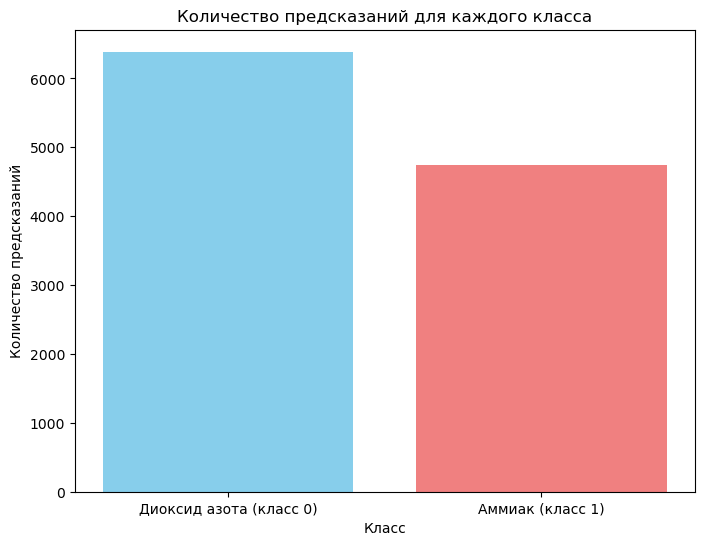

Вероятность принадлежности к классу диоксида азота: 0.9659884683787823 - это диоксид азота
Вероятность принадлежности к классу диоксида азота: 0.9659884683787823 - это диоксид азота
Вероятность принадлежности к классу диоксида азота: 0.9659884683787823 - это диоксид азота
Вероятность принадлежности к классу аммиака: 0.9883176684379578 - это аммиак
Вероятность принадлежности к классу аммиака: 0.7537530660629272 - это аммиак
Вероятность принадлежности к классу диоксида азота: 0.9659884683787823 - это диоксид азота
Вероятность принадлежности к классу аммиака: 0.7537530660629272 - это аммиак
Вероятность принадлежности к классу диоксида азота: 0.9659884683787823 - это диоксид азота
Вероятность принадлежности к классу аммиака: 0.9279177188873291 - это аммиак
Вероятность принадлежности к классу аммиака: 0.7537530660629272 - это аммиак
Вероятность принадлежности к классу диоксида азота: 0.9659884683787823 - это диоксид азота
Вероятность принадлежности к классу аммиака: 0.927868127822876 - это 

In [257]:
# Преобразование тестовых данных
x_test_tensor = torch.tensor(X_test, dtype=torch.float32)
#y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Оценка на тестовой выборке
with torch.no_grad():
    test_outputs = model(x_test_tensor.unsqueeze(1))
    test_predictions = (test_outputs > 0.5).float()
    #test_accuracy = accuracy_score(y_test_tensor.numpy(), test_predictions.squeeze(1).numpy())

#print(f'Test Accuracy: {test_accuracy:.4f}')
# Подсчет количества предсказаний для каждого класса
class_counts = test_predictions.squeeze(1).numpy()
unique, counts = np.unique(class_counts, return_counts=True)
class_counts_dict = dict(zip(unique, counts))

# Построение графика
labels = ['Диоксид азота (класс 0)', 'Аммиак (класс 1)']
counts = [class_counts_dict.get(0.0,0), class_counts_dict.get(1.0,0)] #Обработка случая, если какого-то класса нет в предсказаниях

plt.figure(figsize=(8, 6))
plt.bar(labels, counts, color=['skyblue', 'lightcoral'])
plt.title('Количество предсказаний для каждого класса')
plt.ylabel('Количество предсказаний')
plt.xlabel('Класс')
plt.show()

nh3 = 0
no2 = 0
# Логика для вывода класса
for i, prob in enumerate(test_outputs.squeeze(1)):
    if prob.item() > 0.5:
        nh3+=1
        print(f"Вероятность принадлежности к классу аммиака: {prob.item()} - это аммиак")
    else:
        no2+=1
        print(f"Вероятность принадлежности к классу диоксида азота: {1-prob.item()} - это диоксид азота")
print(f"Количество предсказаний за аммиак: {nh3}")
print(f"Количество предсказаний за диоксид азота: {no2}")